In [1]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

python_direct = "Python direct"
numba_direct = "Numba direct"
python_iterative = "Python iterative"
numba_iterative = "Numba iterative"

data = {
    # python_direct: load_data('/home/porepy/simulations/stats/fpm_1_sticking_direct_python.json'),
    # numba_direct: load_data('/home/porepy/simulations/stats/fpm_1_sticking_direct_numba.json'),
    python_iterative: load_data('/home/porepy/simulations/stats/fpm_1_sticking_solver_1_python.json'),
    numba_iterative: load_data('/home/porepy/simulations/stats/fpm_1_sticking_solver_1_numba.json'),
}

def compare(data, func, xlabel, ylabel, color_converged=False):
    plt.figure(figsize=(12, 10))
    for i, (name, entry) in enumerate(data.items()):
        plt.subplot(2, 2, i+1)
        legend = i == 8
        if color_converged:
            color_converged_reason(entry, legend=legend)
        plt.gca().grid(True)
        plt.title(name)
        plt.plot(func(entry))
        if i % 2 == 0:
            plt.ylabel(ylabel)
        if i >= 6:
            plt.xlabel(xlabel)
        # plt.yscale('log')
        if legend:
            plt.legend()


def compare1(data, func, xlabel, ylabel):
    plt.figure()
    for i, (name, entry) in enumerate(data.items()):
        plt.gca().grid(True)
        plt.title(name)
        plt.plot(func(entry), label=name, alpha=0.6, marker='.')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()

* On the bad time step, invert twice and ensure that they give the same result.
* Potentially different solutions because of convergence criterion.

(0.0, 70.0)

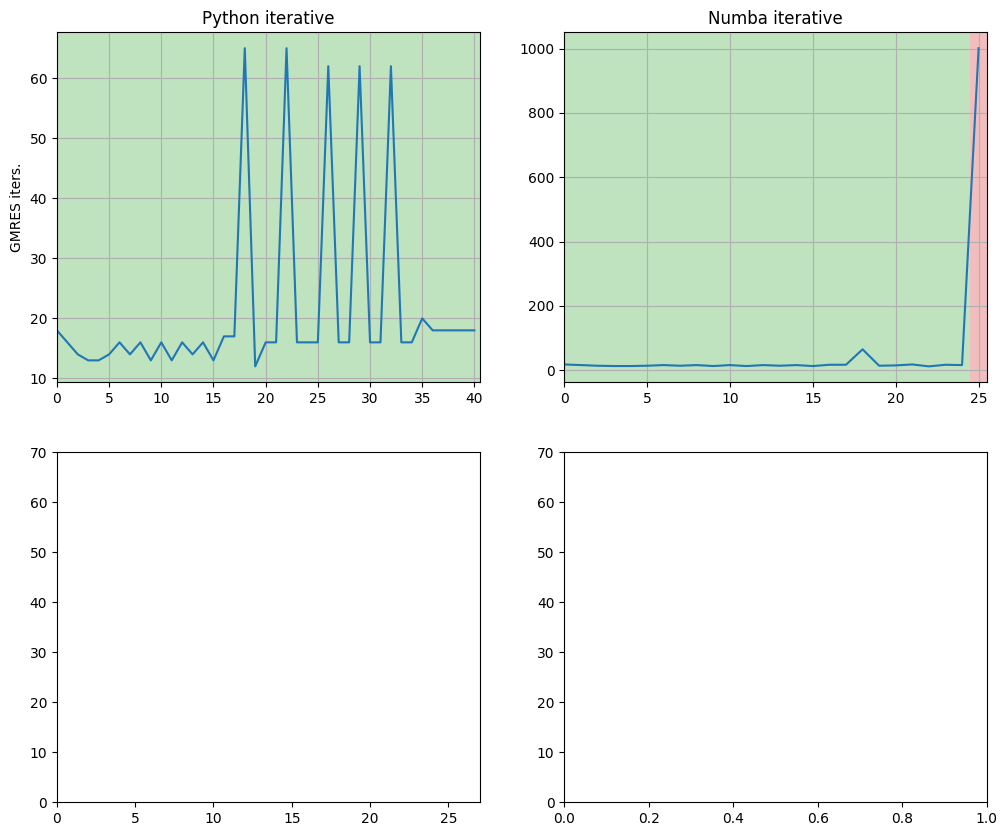

In [2]:
compare(data, get_gmres_iterations, xlabel='# matrix', ylabel='GMRES iters.', color_converged=True)
plt.subplot(2, 2, 3).set_xlim(right=27)
plt.subplot(2, 2, 4).set_ylim(top=70, bottom=0)
plt.subplot(2, 2, 3).set_ylim(top=70, bottom=0)

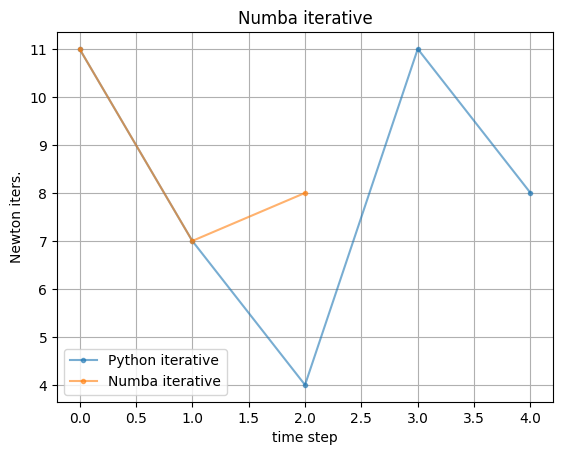

In [3]:
compare1(data, get_newton_iterations, xlabel='time step', ylabel='Newton iters.')

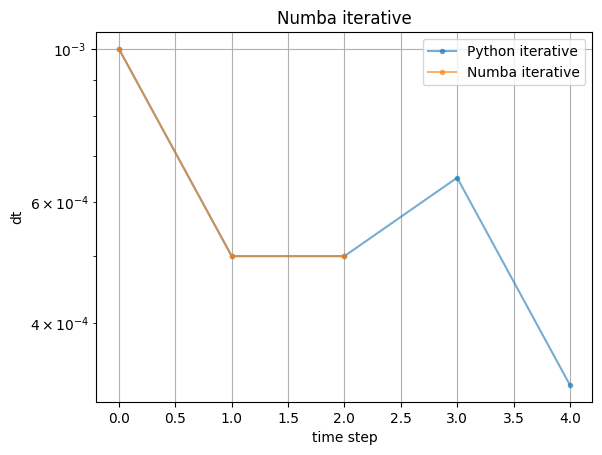

In [4]:
compare1(data, get_time_steps, xlabel='time step', ylabel='dt')
plt.yscale('log')

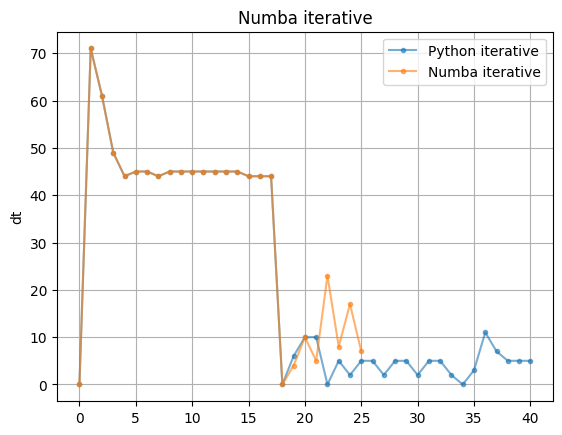

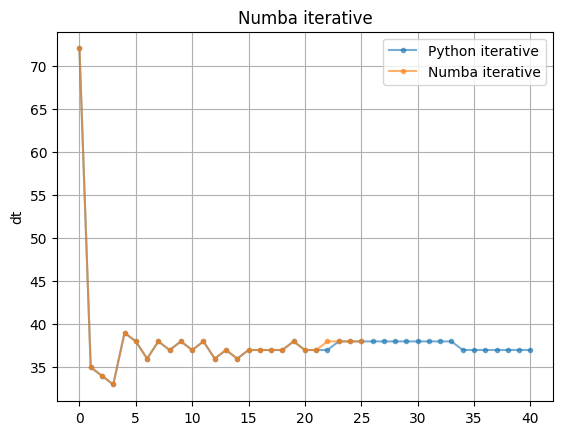

In [20]:
compare1(data, lambda entry: get_num_sticking_sliding_open(entry)[1], xlabel='', ylabel='dt'); plt.show()
compare1(data, lambda entry: get_num_transition_cells(entry), xlabel='', ylabel='dt')

In [153]:
idx = 21
mat_d, rhs_d, state_d, iterate_d, dt = load_matrix_rhs_state_iterate_dt(data[python_iterative], idx=idx)
mat_i, rhs_i, state_i, iterate_i, dt = load_matrix_rhs_state_iterate_dt(data[numba_iterative], idx=idx)

print(f"{mat_d - mat_i = }")
print(f"{rhs_d - rhs_i = }")
print(f"{state_d - state_i = }")
print(f"{iterate_d - iterate_i = }")

mat_d - mat_i = <7509x7509 sparse matrix of type '<class 'numpy.float64'>'
	with 231777 stored elements in Compressed Sparse Row format>
rhs_d - rhs_i = array([-1.50461677e-24, -5.13573515e-25, -4.86516004e-26, ...,
       -2.64697796e-23, -4.76456033e-22, -9.52912066e-22])
state_d - state_i = array([ 4.98732999e-18, -4.18518979e-18, -4.58702222e-17, ...,
        2.63724555e-16,  0.00000000e+00,  2.60607474e-16])
iterate_d - iterate_i = array([-6.32126829e-09,  3.31060490e-09, -3.15997056e-10, ...,
        7.35744622e-10,  0.00000000e+00,  1.25978908e-09])


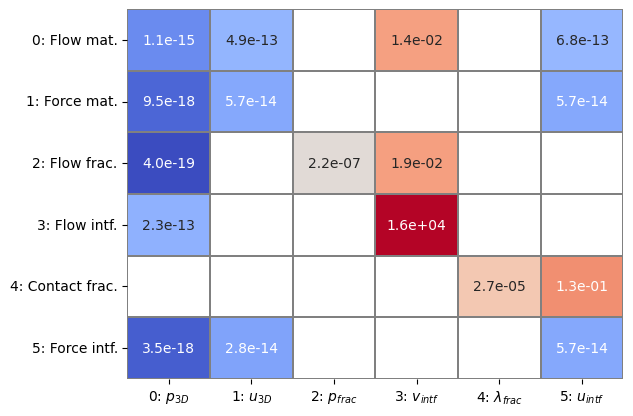

In [154]:
from porepy import plot_grid
from fpm_1 import make_model
from pp_utils import make_reorder_contact
from block_matrix import BlockMatrixStorage, SolveSchema, make_solver
from mat_utils import PetscAMGMechanics, PetscAMGFlow
from pp_utils import correct_eq_groups, get_fixed_stress_stabilization


model = make_model()
model.prepare_simulation()
model.assemble_linear_system()
model._initialize_solver()

reorder = make_reorder_contact(model)
corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)

def make_J(mat):
    mat = mat[reorder]
    return BlockMatrixStorage(
        mat=mat,
        global_row_idx=corrected_eq_dofs,
        global_col_idx=model.var_dofs,
        groups_row=corrected_eq_groups,
        groups_col=model._variable_groups,
        # group_row_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
        # group_col_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']
        # group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
        # group_col_names=[r'$p_{3D}$', r'$u_{3D}$', '', '', '', '']
        group_row_names=[
            r"Flow mat.",
            r"Force mat.",
            r"Flow frac.",
            r"Flow intf.",
            r"Contact frac.",
            "Force intf.",
        ],
        group_col_names=[
            r"$p_{3D}$",
            r"$u_{3D}$",
            r"$p_{frac}$",
            r"$v_{intf}$",
            r"$\lambda_{frac}$",
            "$u_{intf}$",
        ],
    )


J_i = make_J(mat_i)
J_d = make_J(mat_d)

J_diff = J_i.copy()
J_diff.mat -= J_d.mat
J_diff[:].plot_max()

/tmp/ipykernel_28353/556511049.py:5: RuntimeWarning: divide by zero encountered in log10
  model.equation_system.set_variable_values(np.log10(abs(iterate_d - iterate_i)), time_step_index=0)


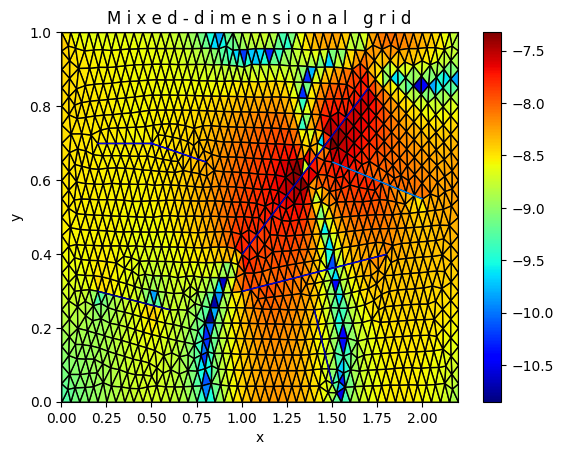

In [155]:
model.equation_system.set_variable_values(np.zeros_like(iterate_d), iterate_index=0)
model.equation_system.set_variable_values(np.zeros_like(iterate_d), time_step_index=0)

# model.equation_system.set_variable_values(np.log10(np.maximum(abs(state_d - state_i), 1e-20)), time_step_index=0)
model.equation_system.set_variable_values(np.log10(abs(iterate_d - iterate_i)), time_step_index=0)
# model.equation_system.set_variable_values(np.log10(abs(rhs_d - rhs_i)), time_step_index=0)

plot_grid(model.mdg, 'pressure', plot_2d=True)

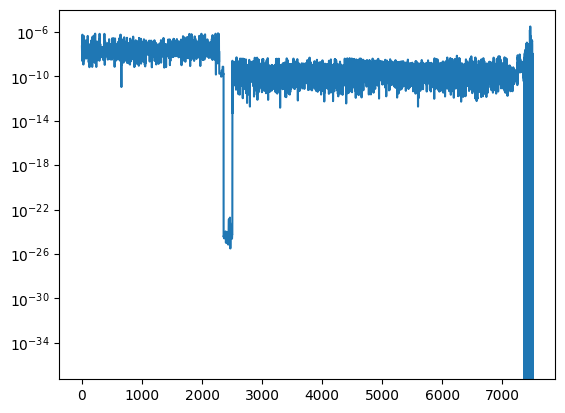

In [156]:
from scipy.sparse.linalg import spsolve
from plot_utils import plot_diff

x_i = spsolve(mat_i, rhs_i)
x_d = spsolve(mat_d, rhs_d)

plot_diff(x_d, x_i)

In [157]:
schema1 = SolveSchema(
    groups=[4, 5],
    complement=SolveSchema(
        groups=[1],
        # invertor=lambda: get_fixed_stress_stabilization(model),
        # invertor_type="physical",
        solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
        # complement=SolveSchema(
        #     groups=[0],
        #     solve=lambda bmat: PetscAMGFlow(mat=bmat.mat),
        # ),
    ),
)

In [158]:
from preconditioner_mech import make_J44_inv


schema2 = SolveSchema(
    groups=[4],
    solve=lambda bmat: make_J44_inv(model=model, bmat=J_i, lump=False),
    complement=SolveSchema(
        groups=[1, 5],
        solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
        # invertor_type="physical",
        # invertor=lambda: get_fixed_stress_stabilization_nd(model),
        # complement=SolveSchema(
        #     groups=[0, 2],
        #     solve=lambda bmat: PetscAMGFlow(bmat.mat),
        # ),
    ),
)

There is something fundamentally very bad in J_i, contact mechanics.
Potentially connected to sliding state. But something else

Solve  took: 0.12


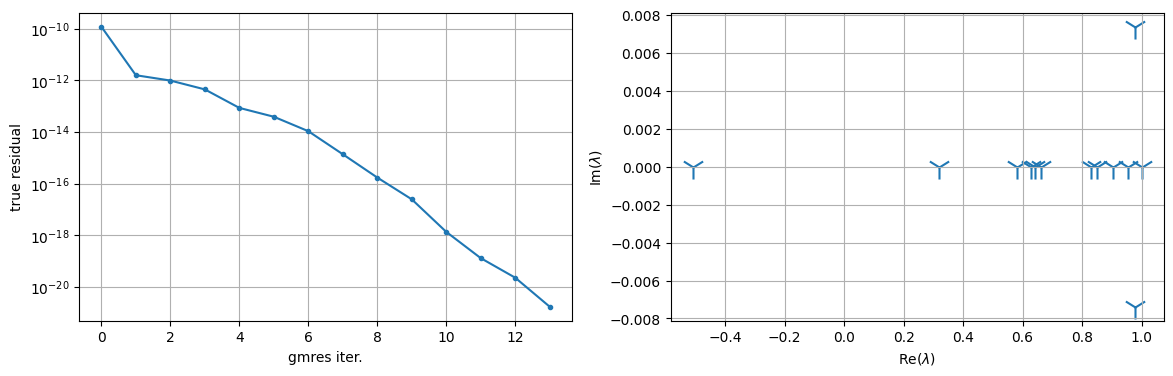

In [159]:
mat_perm, prec  = make_solver(schema1, J_i)
solve_petsc(mat_perm.mat, prec, rhs=mat_perm.local_rhs(rhs_i))

In [163]:
data[numba_iterative][2].linear_solves

[LinearSolveStats(time_invert_F=-1, time_prepare_mass=-1, time_prepare_momentum=-1, time_prepare_solver=0.3294661045074463, time_gmres=0.9970026016235352, gmres_iters=65, time_solve_linear_system=1.3351871967315674, simulation_dt=0.0005, matrix_id='fpm_1_sticking_solver_1_numba_1711467659621.npz', rhs_id='fpm_1_sticking_solver_1_numba_1711467659621_rhs.npy', state_id='fpm_1_sticking_solver_1_numba_1711467659621_state.npy', iterate_id='fpm_1_sticking_solver_1_numba_1711467659621_iterate.npy', petsc_converged_reason=2, num_sticking_sliding_open=[72, 0, 0], sticking=[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [178]:
idx = np.where(data[numba_iterative][2].linear_solves[-1].transition_sticking_sliding)[0]
idx *= 2
idx += 1

In [180]:
%matplotlib tk
J_i[4, 4].color_spy(show=False)
plt.scatter(idx, idx, c='red', marker='x')

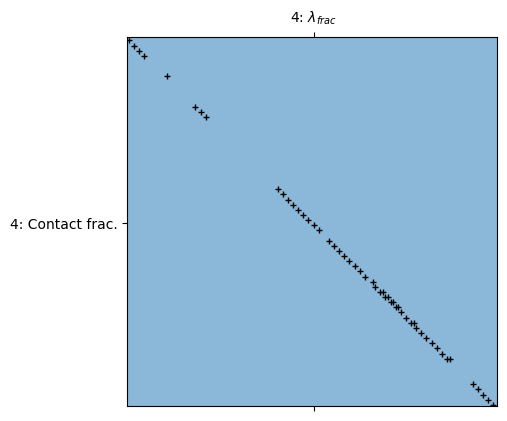

In [148]:
J_d[4, 4].color_spy()

Solve  took: 0.09


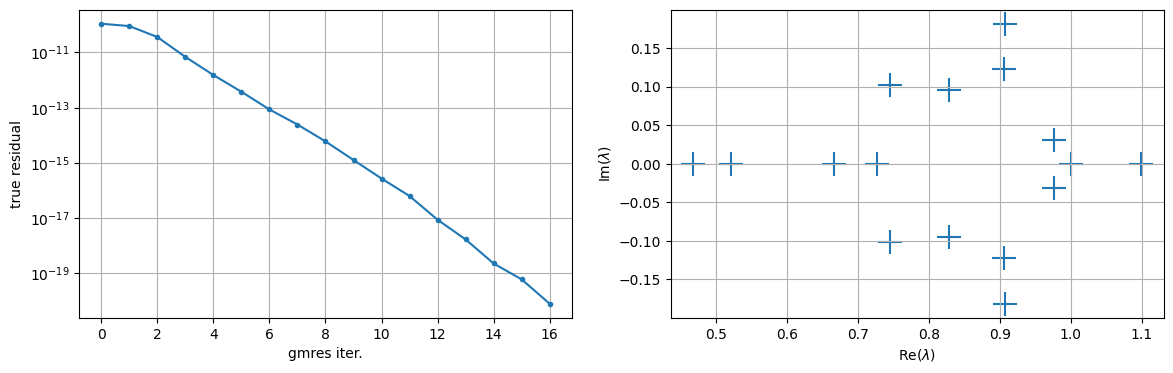

In [149]:

schema2 = SolveSchema(
    groups=[4],
    solve=lambda bmat: make_J44_inv(model=model, bmat=J_d, lump=False),
    complement=SolveSchema(
        groups=[1, 5],
        solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
        # invertor_type="physical",
        # invertor=lambda: get_fixed_stress_stabilization_nd(model),
        # complement=SolveSchema(
        #     groups=[0, 2],
        #     solve=lambda bmat: PetscAMGFlow(bmat.mat),
        # ),
    ),
)

mat_perm, prec  = make_solver(schema2, J_d)
solve_petsc(mat_perm.mat, prec, rhs=mat_perm.local_rhs(rhs_d))

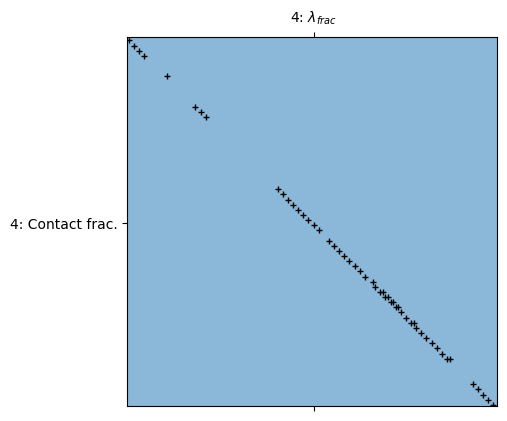

In [150]:
J_d[4, 4].color_spy()

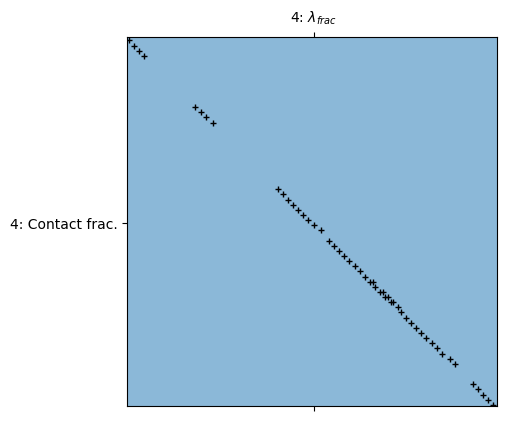

In [151]:
J_i[4, 4].color_spy()

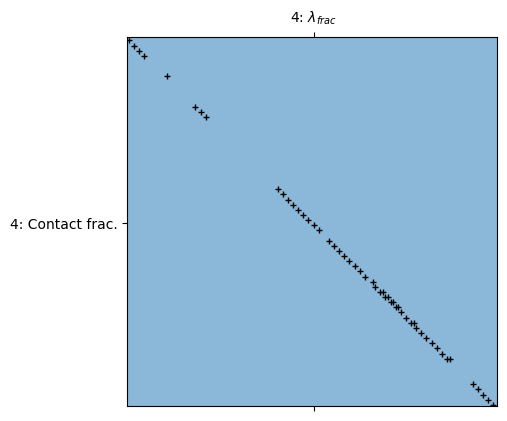

In [152]:
J_d[4, 4].color_spy()